#notebook setup

In [0]:
!pip install google-auth --upgrade
!pip install grpcio --upgrade

Requirement already up-to-date: google-auth in /usr/local/lib/python3.6/dist-packages (1.10.0)
Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.26.0)


In [0]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 37kB/s 
     |████████████████████████████████| 3.8MB 37.9MB/s 
     |████████████████████████████████| 450kB 63.6MB/s 


In [0]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.0.0-dev20191002
Found GPU at: /device:GPU:0


In [0]:
import sys
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler
import pywt
import os
from PIL import Image
# import tensorflow as tf
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

def plot_hist(input_history, filename):
  import os

  folder = ['acc1', 'loss1']

  directory = cwd + '/model_performance/'

  for f in folder:
    if not os.path.exists(directory + f):
      os.makedirs(directory + f)

  # summarize history for accuracy
  # fig, ax = plt.subplots(1,2)
  # plt.subplots_adjust(right=2)

  plt.plot(input_history.history['accuracy'])
  plt.plot(input_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.savefig(cwd+'/model_performance/acc/' + filename + '.jpg')
  plt.show()
  
  # summarize history for loss
  plt.plot(input_history.history['loss'])
  plt.plot(input_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  
  plt.savefig(cwd+'/model_performance/loss/' + filename + '.jpg')

# Data prep

In [109]:
%cd drive/'My Drive'
!pwd

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive
/content/drive/My Drive


In [110]:
!pwd

/content/drive/My Drive


In [111]:
img_folder = '/filtered_images'
!ls 'filtered_images'

0  1  2


class 0 : DYjets
class 1 : TTjets
class 2 : Wjets

## Train val size setting

In [112]:
cwd = os.getcwd()
img_path = cwd + img_folder

train_val_size = 1200

df = {}
data = []
for idx, x in enumerate(os.listdir(img_path)):
  if x.isdigit() and idx < 3:
    for idx2, pic in enumerate(os.listdir(img_path+'/'+str(x))):
      if idx2 < train_val_size:
        data.append((img_path+ '/' + x + '/' + pic , x))

df = pd.DataFrame(data, columns=['filename', 'class'])
df['class'] = df['class'].astype(int)
#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename  class
0  /content/drive/My Drive/filtered_images/2/Wjet...      2
1  /content/drive/My Drive/filtered_images/0/DYje...      0
2  /content/drive/My Drive/filtered_images/1/TTje...      1
3  /content/drive/My Drive/filtered_images/0/DYje...      0
4  /content/drive/My Drive/filtered_images/0/DYje...      0
3600


filename    object
class        int64
dtype: object

In [113]:
from collections import Counter
cnt = Counter(df['class'])
cnt

Counter({0: 1200, 1: 1200, 2: 1200})

In [114]:
# Split into train and validation sets
train_percentage = .8
val_percentage = 0.1
test_percentage = 0.1

train_length = int(len(df) * train_percentage)
df_train = df[:train_length]

val_length = int(len(df) * val_percentage)
df_val = df[train_length : train_length+val_length]

test_length = int(len(df) * test_percentage)
df_test = df[ train_length + val_length : ]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

df_list = [df_train, df_val, df_test]
for df_part in df_list:
  print(len(df_part))

2880
360
360


#### image parsing

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 200,200
num_classes = len(set(df['class']))
batch_size = 120

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [119]:
train_dataset

<BatchDataset shapes: ((120, 200, 200, 3), (120, 3)), types: (tf.float32, tf.float32)>

# ResNet50

## Entirely frozen

In [0]:
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(200,200,3),
    pooling=None
)

In [0]:
x = resnet_50.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)


In [0]:
# this is the model we will train
base_resnet50_model = Model(inputs=resnet_50.input, outputs=predictions)

In [123]:
base_resnet50_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [124]:
for layer in resnet_50.layers:
    print(layer.name)
    layer.trainable = False

input_7
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [125]:
for layer in base_resnet50_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_7  Trainable = False
conv1_pad  Trainable = False
conv1_conv  Trainable = False
conv1_bn  Trainable = False
conv1_relu  Trainable = False
pool1_pad  Trainable = False
pool1_pool  Trainable = False
conv2_block1_1_conv  Trainable = False
conv2_block1_1_bn  Trainable = False
conv2_block1_1_relu  Trainable = False
conv2_block1_2_conv  Trainable = False
conv2_block1_2_bn  Trainable = False
conv2_block1_2_relu  Trainable = False
conv2_block1_0_conv  Trainable = False
conv2_block1_3_conv  Trainable = False
conv2_block1_0_bn  Trainable = False
conv2_block1_3_bn  Trainable = False
conv2_block1_add  Trainable = False
conv2_block1_out  Trainable = False
conv2_block2_1_conv  Trainable = False
conv2_block2_1_bn  Trainable = False
conv2_block2_1_relu  Trainable = False
conv2_block2_2_conv  Trainable = False
conv2_block2_2_bn  Trainable = False
conv2_block2_2_relu  Trainable = False
conv2_block2_3_conv  Trainable = False
conv2_block2_3_bn  Trainable = False
conv2_block2_add  Trainable = False
c

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
base_resnet50_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])


#### fitting the model

In [128]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)
epochs = 50

#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)

resnet_model_filepath = 'CMS/entirely_frozen_resnet50_RMSprop.h5'
#resnet_model_filepath = 'CMS/entirely_frozen_resnet50.h5'
mcp = ModelCheckpoint(resnet_model_filepath, monitor='accuracy', save_best_only=True, mode='max')

### Train the model with validation 
entirely_frozen_resnet50_history = base_resnet50_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks= [#es, 
                               mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 17s 690ms/step - loss: 1.0463 - accuracy: 0.4826 - val_loss: 1.0979 - val_accuracy: 0.4056
Epoch 2/50
24/24 [==============================] - 12s 509ms/step - loss: 0.8126 - accuracy: 0.6156 - val_loss: 1.1237 - val_accuracy: 0.3694
Epoch 3/50
24/24 [==============================] - 12s 506ms/step - loss: 0.7266 - accuracy: 0.6500 - val_loss: 1.0445 - val_accuracy: 0.5000
Epoch 4/50
24/24 [==============================] - 12s 519ms/step - loss: 0.6642 - accuracy: 0.6854 - val_loss: 1.0507 - val_accuracy: 0.4111
Epoch 5/50
24/24 [==============================] - 12s 513ms/step - loss: 0.6276 - accuracy: 0.7167 - val_loss: 1.0656 - val_accuracy: 0.4139
Epoch 6/50
24/24 [==============================] - 12s 510ms/step - loss: 0.6090 - accuracy: 0.7260 - val_loss: 1.0702 - val_accuracy: 0.4111
Epoch 7/50
24/24 [==============================] - 12s 511ms/step - los

In [129]:
pwd


'/content/drive/My Drive'

#### testing the model

In [130]:
test_steps = int(len(df_test)/batch_size)

metrics = base_resnet50_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 397ms/step - loss: 3.4484 - accuracy: 0.3694
model accuracy: 0.36944443


#### plotting training

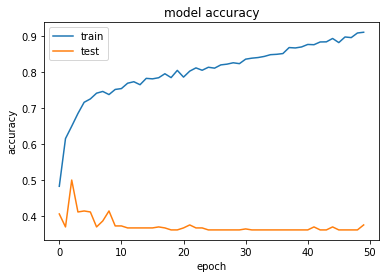

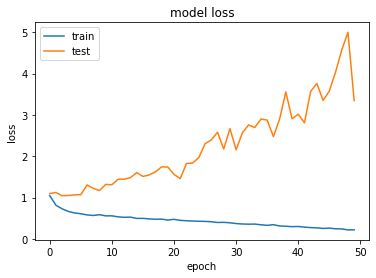

In [131]:
plot_hist(entirely_frozen_resnet50_history, 'entirely_frozen_resnet50_RMSprop')

#### saving the history of the fitting

In [132]:

with open(cwd + '/trainHistoryDict/basic_resnet50_history_prop.p', 'wb') as file_pi:
        pickle.dump(entirely_frozen_resnet50_history.history, file_pi)
print('history saved')

history saved


## Few layers unfrozen

#### loading model

In [0]:
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(200,200,3),
    pooling=None
)

#### modifying slightly

In [0]:
x = resnet_50.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)


#### creating model object

In [0]:
# this is the model we will train
few_unfrozen_resnet_model = Model(inputs=resnet_50.input, outputs=predictions)

In [0]:
for layer in resnet_50.layers:
    print(layer.name)
    layer.trainable = False

input_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [0]:
few_unfrozen_resnet_model.trainable = True
trainable_count = 0

set_trainable = False
for layer in few_unfrozen_resnet_model.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

print('percent unfrozen:', trainable_count/ len(resnet_50.layers) * 100 , '%')


percent unfrozen: 22.857142857142858 %


In [0]:
for layer in few_unfrozen_resnet_model.layers:
    print(layer.name,layer.trainable)

input_3 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
few_unfrozen_resnet_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [0]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'CMS/few_unfrozen_resnet50_RMSprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
few_unfrozen_resnet50_history = few_unfrozen_resnet_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 18s 746ms/step - loss: 0.8451 - accuracy: 0.6056 - val_loss: 1.0626 - val_accuracy: 0.3667
Epoch 2/50
24/24 [==============================] - 13s 562ms/step - loss: 0.5820 - accuracy: 0.7403 - val_loss: 0.9898 - val_accuracy: 0.5250
Epoch 3/50
24/24 [==============================] - 13s 560ms/step - loss: 0.4528 - accuracy: 0.8024 - val_loss: 1.0923 - val_accuracy: 0.3694
Epoch 4/50
24/24 [==============================] - 13s 559ms/step - loss: 0.3586 - accuracy: 0.8382 - val_loss: 1.0330 - val_accuracy: 0.4222
Epoch 5/50
24/24 [==============================] - 14s 569ms/step - loss: 0.2653 - accuracy: 0.8847 - val_loss: 1.0642 - val_accuracy: 0.3778
Epoch 6/50
24/24 [==============================] - 14s 564ms/step - loss: 0.1764 - accuracy: 0.9205 - val_loss: 0.9773 - val_accuracy: 0.5167
Epoch 7/50
24/24 [==============================] - 14s 569ms/step - los

#### testing the model

In [0]:
test_steps = int(len(df_test)/batch_size)

metrics = few_unfrozen_resnet_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 394ms/step - loss: 29.9395 - accuracy: 0.3111
model accuracy: 0.31111112


#### plotting training

In [0]:
pwd

'/content/drive/My Drive'

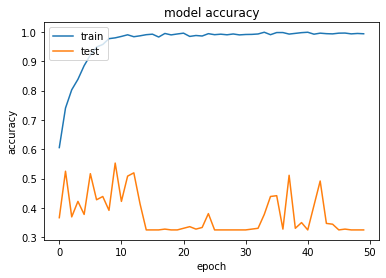

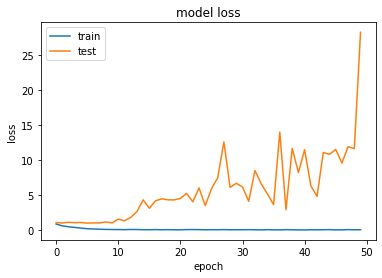

In [0]:
plot_hist(few_unfrozen_resnet50_history, 'few_unfrozen_resnet50_RMSprop')

#### saving the history of the fitting

In [0]:
with open(cwd + '/trainHistoryDict/few_unfrozen_resnet50_history_RMSprop.p', 'wb') as file_pi:
        pickle.dump(few_unfrozen_resnet50_history.history, file_pi)
print('history saved')

history saved


## Many layers unfrozen

#### loading model

In [0]:
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(200,200,3),
    pooling=None
)

#### modifying slightly

In [0]:
x = resnet_50.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
many_unfrozen_resnet_model = Model(inputs=resnet_50.input, outputs=predictions)

In [0]:
for layer in resnet_50.layers:
    print(layer.name)
    layer.trainable = False

input_4
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [0]:
many_unfrozen_resnet_model.trainable = True
trainable_count = 0

set_trainable = False


for layer in many_unfrozen_resnet_model.layers:
    if layer.name == 'conv3_block2_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

print('percent unfrozen:', trainable_count/ len(resnet_50.layers) * 100 , '%')

percent unfrozen: 75.42857142857143 %


In [0]:
for layer in many_unfrozen_resnet_model.layers:
    print(layer.name,layer.trainable)

input_4 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
many_unfrozen_resnet_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [0]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'CMS/many_unfrozen_resnet50_RMSprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 

many_unfrozen_resnet50_history = many_unfrozen_resnet_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 25s 1s/step - loss: 0.8305 - accuracy: 0.6153 - val_loss: 1.0167 - val_accuracy: 0.4583
Epoch 2/50
24/24 [==============================] - 19s 774ms/step - loss: 0.5818 - accuracy: 0.7476 - val_loss: 0.8698 - val_accuracy: 0.5278
Epoch 3/50
24/24 [==============================] - 18s 758ms/step - loss: 0.4748 - accuracy: 0.7913 - val_loss: 1.4566 - val_accuracy: 0.3861
Epoch 4/50
24/24 [==============================] - 18s 757ms/step - loss: 0.4268 - accuracy: 0.8139 - val_loss: 3.5525 - val_accuracy: 0.3722
Epoch 5/50
24/24 [==============================] - 18s 765ms/step - loss: 0.3580 - accuracy: 0.8340 - val_loss: 1.1549 - val_accuracy: 0.6194
Epoch 6/50
24/24 [==============================] - 19s 776ms/step - loss: 0.3028 - accuracy: 0.8646 - val_loss: 0.9912 - val_accuracy: 0.5944
Epoch 7/50
24/24 [==============================] - 18s 767ms/step - loss: 

#### testing the model

In [0]:
test_steps = int(len(df_test)/batch_size)

metrics = many_unfrozen_resnet_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 420ms/step - loss: 34.0991 - accuracy: 0.4028
model accuracy: 0.4027778


#### plotting training

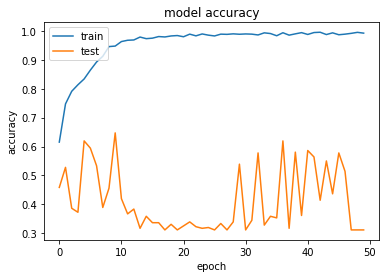

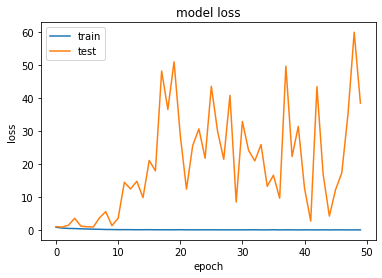

In [0]:
plot_hist(many_unfrozen_resnet50_history, 'many_unfrozen_resnet50_RMSprop')

#### saving the history of the fitting

In [0]:
with open(cwd + '/trainHistoryDict/many_unfrozen_resnet50_history_RMSprop.p', 'wb') as file_pi:
        pickle.dump(many_unfrozen_resnet50_history.history, file_pi)
print('history saved')

history saved


## entirely unfrozen

In [0]:
resnet_50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(200,200,3),
    pooling=None
)

#### modifying slightly

In [0]:
x = resnet_50.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
unfrozen_resnet50_model = Model(inputs=resnet_50.input, outputs=predictions)

In [0]:
for layer in unfrozen_resnet50_model.layers:
    print(layer.name)
    layer.trainable = True

input_5
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [0]:
for layer in unfrozen_resnet50_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_5  Trainable = True
conv1_pad  Trainable = True
conv1_conv  Trainable = True
conv1_bn  Trainable = True
conv1_relu  Trainable = True
pool1_pad  Trainable = True
pool1_pool  Trainable = True
conv2_block1_1_conv  Trainable = True
conv2_block1_1_bn  Trainable = True
conv2_block1_1_relu  Trainable = True
conv2_block1_2_conv  Trainable = True
conv2_block1_2_bn  Trainable = True
conv2_block1_2_relu  Trainable = True
conv2_block1_0_conv  Trainable = True
conv2_block1_3_conv  Trainable = True
conv2_block1_0_bn  Trainable = True
conv2_block1_3_bn  Trainable = True
conv2_block1_add  Trainable = True
conv2_block1_out  Trainable = True
conv2_block2_1_conv  Trainable = True
conv2_block2_1_bn  Trainable = True
conv2_block2_1_relu  Trainable = True
conv2_block2_2_conv  Trainable = True
conv2_block2_2_bn  Trainable = True
conv2_block2_2_relu  Trainable = True
conv2_block2_3_conv  Trainable = True
conv2_block2_3_bn  Trainable = True
conv2_block2_add  Trainable = True
conv2_block2_out  Trainable =

#### setting the optimizer

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)

# compile the model (should be done *after* setting layers to non-trainable)
unfrozen_resnet50_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [0]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'CMS/unfrozen_resnet50_RMSprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
unfrozen_resnet50_history = unfrozen_resnet50_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 31s 1s/step - loss: 0.8441 - accuracy: 0.5979 - val_loss: 0.9775 - val_accuracy: 0.6194
Epoch 2/50
24/24 [==============================] - 22s 916ms/step - loss: 0.5889 - accuracy: 0.7441 - val_loss: 1.0816 - val_accuracy: 0.5417
Epoch 3/50
24/24 [==============================] - 22s 904ms/step - loss: 0.5027 - accuracy: 0.7767 - val_loss: 0.9350 - val_accuracy: 0.5806
Epoch 4/50
24/24 [==============================] - 24s 989ms/step - loss: 0.4278 - accuracy: 0.8101 - val_loss: 1.5867 - val_accuracy: 0.6389
Epoch 5/50
24/24 [==============================] - 22s 918ms/step - loss: 0.3677 - accuracy: 0.8299 - val_loss: 1.6042 - val_accuracy: 0.5694
Epoch 6/50
24/24 [==============================] - 22s 904ms/step - loss: 0.3312 - accuracy: 0.8521 - val_loss: 2.3510 - val_accuracy: 0.6333
Epoch 7/50
24/24 [==============================] - 22s 899ms/step - loss: 

#### testing the model

In [0]:
test_steps = int(len(df_test)/batch_size)

metrics = unfrozen_resnet50_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 402ms/step - loss: 8.2883 - accuracy: 0.6472
model accuracy: 0.6472222


#### plotting training

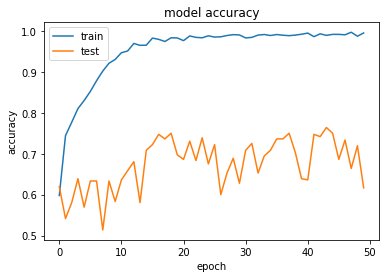

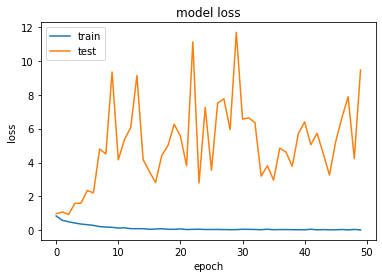

In [0]:
plot_hist(unfrozen_resnet50_history, 'unfrozen_resnet50_RMSprop')

#### saving the history of the fitting

In [0]:
with open(cwd + '/trainHistoryDict/unfrozen_resnet50_history_RMSprop.p', 'wb') as file_pi:
        pickle.dump(unfrozen_resnet50_history.history, file_pi)
print('history saved')

history saved
